## Extracting Scripts

In [ ]:
from glob import glob
subtitles_path = sorted(glob("../data/Subtitles/*.ass"))

In [74]:
subtitles_path[:5]

['./data/Subtitles/Naruto Season 1 - 01.ass',
 './data/Subtitles/Naruto Season 1 - 02.ass',
 './data/Subtitles/Naruto Season 1 - 03.ass',
 './data/Subtitles/Naruto Season 1 - 04.ass',
 './data/Subtitles/Naruto Season 1 - 05.ass']

In [75]:
scripts = []
episode_num = []
for path in subtitles_path:
    
    with open(path, 'r') as file:
        lines = file.readlines()
        lines = lines[27:]
        
        rows = [",".join(line.split(',')[9:]) for line in lines]
    
    rows = [line.replace("\\N", ' ') for line in rows]
    script = " ".join(rows)
    
    episode = int(path.split('-')[1].split('.')[0].strip())
    
    scripts.append(script)
    episode_num.append(episode)

### Arc Data

In [ ]:
arcs = pd.read_csv('../Crawlers/arc_table.csv')

In [91]:
arcs.head()

,Arc Name,Chapters,Episodes,Summary
0,Prologue Land of Waves,1-33,1-19,Naruto Uzumaki
1,Chunin Exams,34-115,20-67,Team 7 participates in the
2,Konoha Crush,116-138,68-80,The village of
3,Search for Tsunade,139-171,81-100,Naruto helps
4,Land of Tea Escort Mission,NaN,102-106,Team 7 goes to the


In [92]:
arcs["filler"] = 0
arcs.loc[arcs["Chapters"].isna(), "filler"] = 1

In [93]:
arcs = arcs[["Arc Name", "Episodes", "filler"]]
arcs.head(5)

,Arc Name,Episodes,filler
0,Prologue Land of Waves,1-19,0
1,Chunin Exams,20-67,0
2,Konoha Crush,68-80,0
3,Search for Tsunade,81-100,0
4,Land of Tea Escort Mission,102-106,1


In [94]:
# Function to expand episode ranges
def expand_episode_range(df):
    expanded_rows = []
    
    for _, row in df.iterrows():
        arc_name = row["Arc Name"]
        episode_range = row["Episodes"]
        filler = row["filler"]

        # Extract episode numbers
        start, end = map(int, episode_range.split('-'))  # Convert "1-19" → (1,19)

        # Create a row for each episode
        for episode in range(start, end + 1):
            expanded_rows.append({"Arc Name": arc_name, "Episode": episode, "Filler": filler})

    # Convert to DataFrame
    return pd.DataFrame(expanded_rows)

arcs = expand_episode_range(arcs)

In [95]:
for ep in set(episode_num) - set(arcs["Episode"].tolist()):
    arcs.loc[len(arcs)] = ["Standalone", ep, 1]

Since the valid scripts available are only of length 218, I'm going to omit the missing episodes since their script writing convention is different.

In [96]:
arcs = arcs[arcs.Episode != 10]
arcs = arcs[arcs.Episode != 11]
arcs = arcs.sort_values("Episode", ascending=True).reset_index(drop=True)

In [97]:
len(arcs)

218

In [98]:
arcs.tail()

,Arc Name,Episode,Filler
213,Sunagakure Support Mission,216,1
214,Sunagakure Support Mission,217,1
215,Sunagakure Support Mission,218,1
216,Sunagakure Support Mission,219,1
217,Sunagakure Support Mission,220,1


### Cleaning Scripts

In [99]:
import pandas as pd
df = pd.DataFrame.from_dict({'episode': episode_num, 'script': scripts})
df = df.merge(arcs, left_on='episode', right_on="Episode")

In [100]:
df.head(10)

,episode,script,Arc Name,Episode,Filler
0,1,"A long time ago, a powerful demon fox appeared...",Prologue Land of Waves,1,0
1,2,"C'mon!\n Running like a fugitive,\n Being chas...",Prologue Land of Waves,2,0
2,3,"C'mon!\n Running like a fugitive,\n Being chas...",Prologue Land of Waves,3,0
3,4,"C'mon!\n Running like a fugitive,\n Being chas...",Prologue Land of Waves,4,0
4,5,"C'mon!\n Running like a fugitive,\n Being chas...",Prologue Land of Waves,5,0
5,6,"C'mon!\n Running like a fugitive,\n Being chas...",Prologue Land of Waves,6,0
6,7,"C'mon!\n Running like a fugitive,\n Being chas...",Prologue Land of Waves,7,0
7,8,"C'mon!\n Running like a fugitive,\n Being chas...",Prologue Land of Waves,8,0
8,9,"C'mon!\n Running like a fugitive,\n Being chas...",Prologue Land of Waves,9,0
9,12,"C'mon!\n Running like a fugitive,\n Being chas...",Prologue Land of Waves,12,0


In [101]:
import spacy
nlp = spacy.load("en_core_web_trf")

##### Script that identifies characters within a script

In [103]:
from nltk import sent_tokenize

def get_ners(script):
    script_sentences = sent_tokenize(script)
    
    ner_output = []
    
    for sentence in script_sentences:
        doc = nlp(sentence)
        ners = set() ## Ensures unique values within a sentence
        for ent in doc.ents:
            if ent.label_ == "PERSON":
                full_name = ent.text
                first_name = full_name.split(' ')[0]
                ners.add(first_name)
        ner_output.append(list(ners))
    return ner_output

In [104]:
df['ners'] = df['script'].apply(get_ners)

In [105]:
df.to_csv('ners_df.csv', index=False)

In [18]:
df.head()

,episode,script,Arc Name,Episode,Filler,ners
0,1,"A long time ago, a powerful demon fox appeared...",Prologue Land of Waves,1,0,"[[], [], [], [], [], [], [], [Naruto], [], [],..."
1,2,"C'mon!\n Running like a fugitive,\n Being chas...",Prologue Land of Waves,2,0,"[[], [], [], [], [], [], [], [], [], [Konohama..."
2,3,"C'mon!\n Running like a fugitive,\n Being chas...",Prologue Land of Waves,3,0,"[[], [], [], [Sasuke, Sakura], [], [Konohamaru..."
3,4,"C'mon!\n Running like a fugitive,\n Being chas...",Prologue Land of Waves,4,0,"[[], [], [], [Naruto], [], [], [Iruka], [], [N..."
4,5,"C'mon!\n Running like a fugitive,\n Being chas...",Prologue Land of Waves,5,0,"[[], [], [], [], [], [], [], [], [], [], [], [..."


##### Crafting relationships by looking into names that appear within 10 line window

In [19]:
window = 10
entity_relationship = []

for row in df['ners']:
    previous_entities_in_window = []
    
    for sentence in row:
        previous_entities_in_window.append(sentence)
        previous_entities_in_window = previous_entities_in_window[(-1 * window):]
        
        previous_entities_flattened = sum(previous_entities_in_window, [])
        
        for entity in sentence:
            for entity_in_window in previous_entities_flattened:
                if entity!=entity_in_window:
                    entity_rel = sorted([entity, entity_in_window])
                    entity_relationship.append(entity_rel)

In [110]:
df.loc[:3, "ners"]

0    [[], [], [], [], [], [], [], [Naruto], [], [],...
1    [[], [], [], [], [], [], [], [], [], [Konohama...
2    [[], [], [], [Sasuke, Sakura], [], [Konohamaru...
3    [[], [], [], [Naruto], [], [], [Iruka], [], [N...
Name: ners, dtype: object

In [125]:
relationship_df = pd.DataFrame({'value': entity_relationship})

relationship_df['source'] = relationship_df['value'].apply(lambda x: x[0])
relationship_df['target'] = relationship_df['value'].apply(lambda x: x[1])

relationship_df = relationship_df.groupby(['source', 'target']).count().reset_index()

In [126]:
relationship_df = relationship_df.sort_values('value', ascending=False).reset_index()
relationship_df.head()

,source,target,value
2895,Naruto,Sasuke,891
3342,Sakura,Sasuke,527
2888,Naruto,Sakura,462
1517,Hinata,Naruto,345
3147,Orochimaru,Sasuke,280


In [17]:
relationship_df.to_csv('relations.csv', index = False)

 ### Wrangling Data
 
 Due to the size of the relationships, we're going to limit the `relationship_df` to about 250 pairings to reduce the crowdiness of our graph

In [1]:
import pandas as pd
import ast

df = pd.read_csv('ners_df.csv')
df["ners"] = df["ners"].apply(ast.literal_eval)

relationship_df = pd.read_csv('relations.csv')
df.head()

,episode,script,Arc Name,Episode,Filler,ners
0,1,"A long time ago, a powerful demon fox appeared...",Prologue Land of Waves,1,0,"[[], [], [], [], [], [], [], [Naruto], [], [],..."
1,2,"C'mon!\n Running like a fugitive,\n Being chas...",Prologue Land of Waves,2,0,"[[], [], [], [], [], [], [], [], [], [Konohama..."
2,3,"C'mon!\n Running like a fugitive,\n Being chas...",Prologue Land of Waves,3,0,"[[], [], [], [Sasuke, Sakura], [], [Konohamaru..."
3,4,"C'mon!\n Running like a fugitive,\n Being chas...",Prologue Land of Waves,4,0,"[[], [], [], [Naruto], [], [], [Iruka], [], [N..."
4,5,"C'mon!\n Running like a fugitive,\n Being chas...",Prologue Land of Waves,5,0,"[[], [], [], [], [], [], [], [], [], [], [], [..."


In [8]:
import networkx as nx
G = nx.from_pandas_edgelist(relationship_df.head(250),
                           source = "source",
                           target = "target",
                           edge_attr = "value",
                           create_using = nx.Graph())

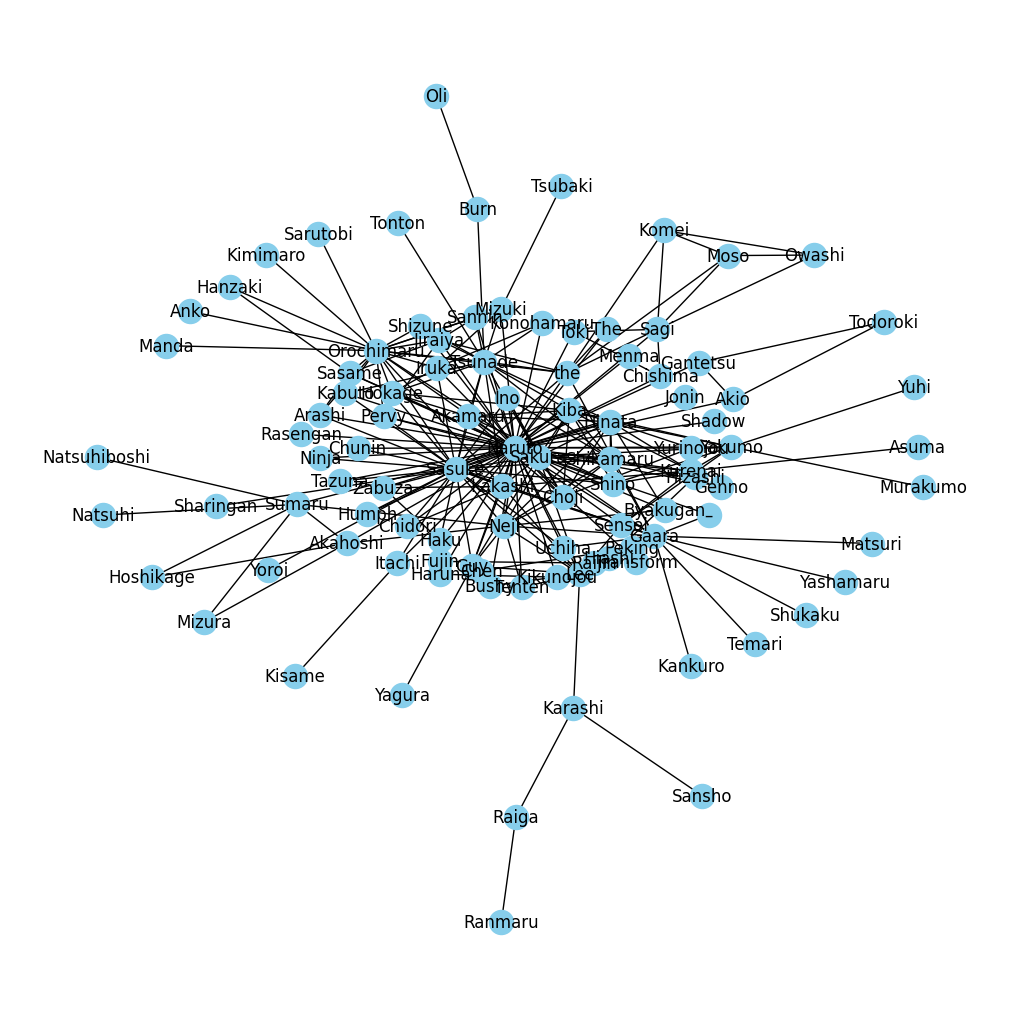

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
pos = nx.kamada_kawai_layout(G)
nx.draw(G, with_labels=True, node_color="skyblue", edge_cmap=plt.cm.Blues, pos=pos)
plt.show()

As a result of the graph being cluttered, we're going to use `pyvis` to lessen this issue.

In [10]:
from pyvis.network import Network
net = Network(notebook = True, width="1000px", height="700px", bgcolor="#222222", font_color="white", filter_menu=True, cdn_resources='in_line')

node_degree = dict(G.degree)

#Setting up node size attribute
nx.set_node_attributes(G, node_degree, 'size')

net.from_nx(G)
net.show("naruto.html")

naruto.html


# Working Implementation

In [45]:
import pandas as pd
import networkx as nx
from pyvis.network import Network
import panel as pn
import html

# Ensure Panel is serving in a Jupyter environment
pn.extension()

# Function to calculate entity relationships
def calculate_relationships(df, max_episode=None, include_filler=True, window=10):
    filtered_df = df.copy()

    if max_episode is not None:
        filtered_df = filtered_df[filtered_df["Episode"] <= max_episode]
    if not include_filler:
        filtered_df = filtered_df[filtered_df["Filler"] == 0]

    entity_relationship = []
    for row in filtered_df['ners']:
        previous_entities_in_window = []
        for sentence in row:
            previous_entities_in_window.append(sentence)
            previous_entities_in_window = previous_entities_in_window[-window:]
            previous_entities_flattened = sum(previous_entities_in_window, [])
            for entity in sentence:
                for entity_in_window in previous_entities_flattened:
                    if entity != entity_in_window:
                        entity_rel = sorted([entity, entity_in_window])
                        entity_relationship.append(entity_rel)

    return entity_relationship

# Function to generate the graph as an iframe
def generate_graph_iframe(entity_relationships):
    if not entity_relationships:
        return "No relationships found."

    relationship_df = pd.DataFrame({'value': entity_relationships})
    relationship_df['source'] = relationship_df['value'].apply(lambda x: x[0])
    relationship_df['target'] = relationship_df['value'].apply(lambda x: x[1])

    relationship_df = relationship_df.groupby(['source', 'target']).count().reset_index()
    relationship_df = relationship_df.sort_values('value', ascending=False)

    G = nx.from_pandas_edgelist(relationship_df.head(250), source="source", target="target", edge_attr="value", create_using=nx.Graph())

    # Build the pyvis network with embedded JavaScript
    net = Network(notebook=False, cdn_resources="remote", width="100%", height="1080px", bgcolor="#222222", font_color="white")
    net.from_nx(G)

    # Generate the HTML for the graph and escape quotes for embedding
    graph_html = net.generate_html()
    escaped_graph_html = html.escape(graph_html, quote=True)

    # Create an iframe to display the graph
    iframe_html = f'<iframe srcdoc="{escaped_graph_html}" width="100%" height="1080px" frameborder="0"></iframe>'
    
    return iframe_html

# Function to create the network graph
def create_network(max_episode, include_filler):
    entity_relationships = calculate_relationships(df, max_episode, include_filler)
    iframe_html = generate_graph_iframe(entity_relationships)
    
    return pn.pane.HTML(iframe_html, sizing_mode="stretch_both")

# Create interactive widgets
episode_slider = pn.widgets.IntSlider(name="Max Episode", start=1, end=max(df["Episode"]), step=1, value=max(df["Episode"]))
filler_toggle = pn.widgets.Checkbox(name="Include Filler", value=True)

# Interactive layout
interactive_plot = pn.bind(create_network, episode_slider, filler_toggle)
layout = pn.Column(episode_slider, filler_toggle, interactive_plot)

# Save interactive panel app to an HTML file
layout.save("interactive_network.html", embed=True)


In [46]:
!pip install --upgrade pyvis